In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)**

Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса K1
, а 2 имеют метку класса K2. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def entropy(cl):
    return -np.sum(cl * np.log(cl)) if np.all(cl != 0) else 0

counts = np.array([8, 2])
entropy = round(entropy(counts / counts.sum()), 2)
entropy

0.5

**Задание 1.2 (0.5 балла)**

Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса K1, а в правое - класса K2.

In [3]:
def gini(p):
    return np.sum(p * (1 - p))

probabilities = counts / counts.sum()

gini_Rm = gini(probabilities)

probabilities_Rl = np.array([1, 0])
gini_Rl = gini(probabilities_Rl)

probabilities_Rr = np.array([0, 1])
gini_Rr = gini(probabilities_Rr)

N_Rm = counts.sum()
N_Rl = counts[0]
N_Rr = counts[1]

Q = gini_Rm - (N_Rl / N_Rm) * gini_Rl - (N_Rr / N_Rm) * gini_Rr

Q = round(Q, 2)
Q

0.32

**Задание 1.3 (0.5 балла)**

Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
target_val = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

mean_prediction = np.mean(target_val)
mean_prediction

40.6

**Часть 2: Решающие деревья (4.5 балла)**

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)**

Реализуйте функцию find_best_split(), которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из Задания 1.2. В качестве меры хаотичности
 для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

In [6]:
def calculate_gini(targets):
    _, counts = np.unique(targets, return_counts=True)
    probabilities = counts / counts.sum()
    return 1 - np.sum(probabilities**2)

def calculate_variance(targets):
    return np.var(targets)

def find_best_split(
    feature_vector: Union[np.ndarray, pd.Series],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    sorted_indices = np.argsort(feature_vector)
    sorted_features = feature_vector[sorted_indices]
    sorted_targets = target_vector[sorted_indices]
    if task == "classification":
        initial_impurity = calculate_gini(sorted_targets)
    else:
        initial_impurity = calculate_variance(sorted_targets)

    best_threshold = None
    best_gini = float('inf')
    threshold_list = []
    gini_list = []

    if feature_type == "real":
        unique_values = np.unique(sorted_features)
        potential_thresholds = (unique_values[:-1] + unique_values[1:]) / 2
    else:
        potential_thresholds = np.unique(sorted_features)

    for threshold in potential_thresholds:
        if feature_type == "real":
            left_mask = sorted_features <= threshold
            right_mask = sorted_features > threshold
        else:
            left_mask = sorted_features == threshold
            right_mask = sorted_features != threshold

        left_targets = sorted_targets[left_mask]
        right_targets = sorted_targets[right_mask]

        if len(left_targets) == 0 or len(right_targets) == 0:
            continue
        if task == "classification":
            gini_left = calculate_gini(left_targets)
            gini_right = calculate_gini(right_targets)
        else:
            gini_left = calculate_variance(left_targets)
            gini_right = calculate_variance(right_targets)

        weighted_gini = (len(left_targets) / len(sorted_targets) * gini_left +
                         len(right_targets) / len(sorted_targets) * gini_right)

        gini_improvement = initial_impurity - weighted_gini
        gini_list.append(gini_improvement)
        threshold_list.append(threshold)

        if gini_improvement < best_gini:
            best_gini = gini_improvement
            best_threshold = threshold

    return np.array(threshold_list), np.array(gini_list), best_threshold, best_gini

In [7]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку MedInc.

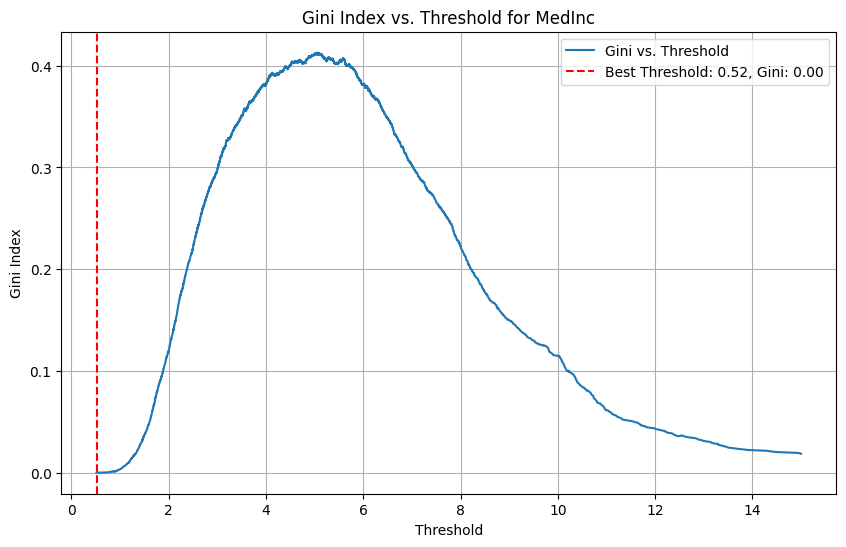

In [ ]:
import matplotlib.pyplot as plt

thresholds, ginis, best_threshold, best_gini = find_best_split(
    X['MedInc'], y, task="regression", feature_type="real"
)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, ginis, label="Gini vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Gini Index")
plt.title("Gini Index vs. Threshold for MedInc")
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}, Gini: {best_gini:.2f}')
plt.legend()
plt.grid(True)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [9]:
best_splits = []
for feature_name in X.columns:
    thresholds, ginis, threshold_best, gini_best = find_best_split(X[feature_name].values, y, task="regression", feature_type="real")
    best_splits.append((feature_name, threshold_best, gini_best))

best_feature, best_threshold, best_improvement = max(best_splits, key=lambda x: x[2], default=(None, None, float('-inf')))

print(f"Best feature: {best_feature}, Best threshold: {best_threshold}, Best improvement: {best_improvement}")

Best feature: MedInc, Best threshold: 0.51795, Best improvement: 0.00010880339847685327


**Задание 2.2 (1 балл)**

Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод _predict_node().

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».

Выбор лучшего разбиения необходимо производить по критерию Джини.
Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
Ответ в листе: наиболее часто встречающийся класс в листе.
В задаче также предлагается получить два бонуса, по баллу на каждый!

Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.
Реализуйте метод оценки важности признаков.

In [10]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self._feature_importances = {}

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict,
        depth: int = 0
    ) -> None:

        # Критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        left_X = sub_X[split]
        right_X = sub_X[np.logical_not(split)]
        left_y = sub_y[split]
        right_y = sub_y[np.logical_not(split)]

        # Проверяем, не пусты ли подвыборки
        if left_X.shape[0] == 0 or right_X.shape[0] == 0:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(left_X, left_y, node["left_child"], depth + 1)
        self._fit_node(right_X, right_y, node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]

        feature_split = node["feature_split"]

        if self._feature_types[feature_split] == "real":
            if x[feature_split] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature_split] == "categorical":
            if x[feature_split] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("Unknown feature type")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._tree = {}
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)


**Задание 2.3 (1 балл)**

Загрузите таблицу students.csv (это немного преобразованный датасет User Knowledge). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [13]:
students_data = pd.read_csv('students.csv')
students_data.drop(columns=['Unnamed: 0'], inplace=True)
students_data

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


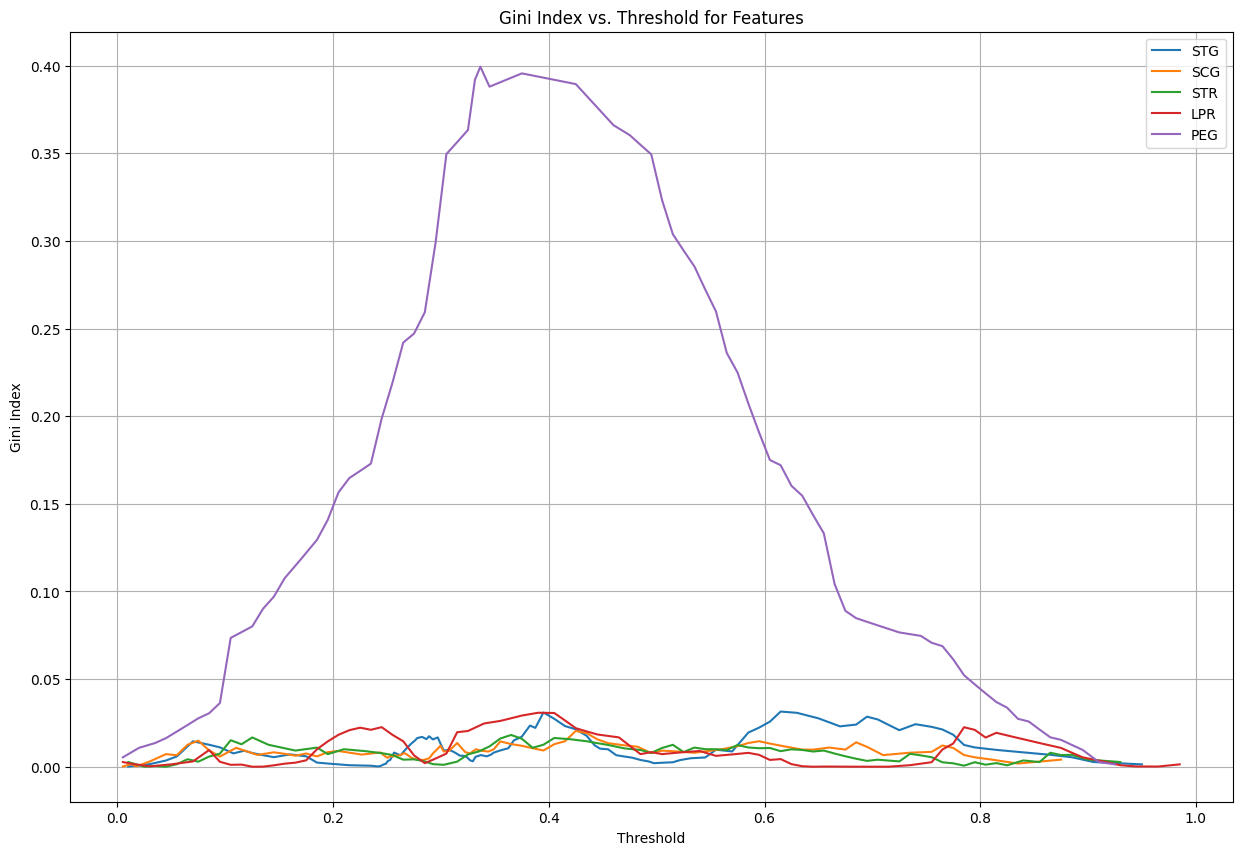

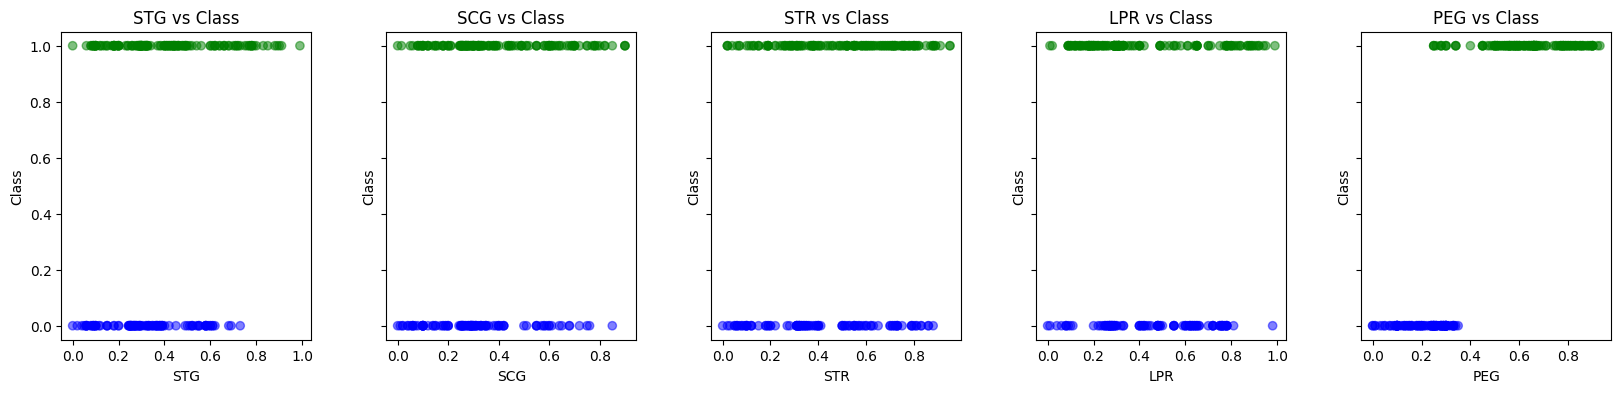

In [14]:
feature_names = students_data.columns[:-1]
target = students_data['UNS'].values

plt.figure(figsize=(15, 10))

for i, feature in enumerate(feature_names):
    feature_values = students_data[feature].values
    thresholds, ginis, _, _ = find_best_split(feature_values, target, task="classification", feature_type="real")
    plt.plot(thresholds, ginis, label=f'{feature}')

plt.title("Gini Index vs. Threshold for Features")
plt.xlabel("Threshold")
plt.ylabel("Gini Index")
plt.legend()
plt.grid(True)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, feature in enumerate(feature_names):
    axes[i].scatter(students_data[feature], students_data['UNS'], alpha=0.5, c=(students_data['UNS']+1).map({1: 'blue', 2: 'green'}))
    axes[i].set_title(f'{feature} vs Class')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Class')

plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Лучший признак для разделения на два поддерева - **PEG**.

Результат согласуется, на диаграмме рассеивания четко виден однозначный переход.

При хороших признаках кривая показывает увеличение коэф. Джинни при определенных порогах. У такой кривой есть пик или пики, показывающие коэф. при котором разделение эффективно уменьшает неопредленность.

При плохом признаке кривая будет плоская, либо почти плоская, это говорит о том, что ни при каком пороге признак не даст хорошее разделение на классы.

**Задание 2.4 (1 балл)**

Протестируйте свое решающее дерево на датасете mushrooms.

Скачайте таблицу agaricus-lepiota.data (из Data Folder),
Считайте таблицу при помощи pandas,
Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

data_path = 'agaricus-lepiota.data'
data = pd.read_csv(data_path, header=None)

X = data.iloc[:, 1:]
y = data.iloc[:, 0]
label_encoders = {}
for column in X.columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

dt = DecisionTree(feature_types=["categorical"] * X.shape[1])
dt.fit(X_train.values, y_train)

y_pred = dt.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
accuracy

<ipython-input-17-a6fca2e37bbf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-17-a6fca2e37bbf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-17-a6fca2e37bbf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

0.5132939438700148

**Часть 3: Бэггинг и случайный лес (4 балла)**

В данной части мы будем работать с задачей предсказания диабета у пациента. Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [11]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [12]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


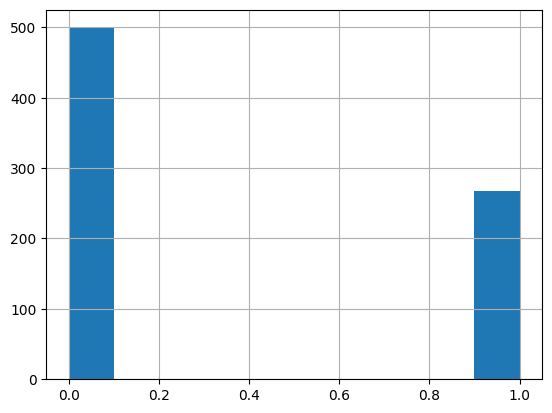

In [20]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)**

 Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [13]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

(X_train_train.shape, X_train_val.shape, X_test.shape)

((375, 8), (162, 8), (231, 8))

**Задание 3.2 (1 балл)**

На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров max_depth и min_samples_leaf для DecisionTreeClassifier. Для этого:

Создайте списки с возможными значениями для перебора.
Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать f1-меру.
Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.
Обучите решающее дерево с подобранными гиперпараметрами на полной обучающей выборке. Оцените качество классификации на тестовой выборке по метрикам accuracy, precision и recall, auc_roc.

In [14]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from collections import Counter

max_depth_values = [1, 3, 5, 7, 10, 15, 20, 30]
min_samples_leaf_values = [1, 2, 4, 6, 8, 10]

results = []

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        dt = DecisionTree(feature_types=['categorical']*X_train_train.shape[1],
                          max_depth=max_depth,
                          min_samples_leaf=min_samples_leaf,
                          task='classification')
        dt.fit(X_train_train.values, y_train_train.values)
        y_val_pred = dt.predict(X_train_val.values)
        f1 = f1_score(y_train_val, y_val_pred)
        results.append((max_depth, min_samples_leaf, f1))

best_params = max(results, key=lambda x: x[2])
best_max_depth, best_min_samples_leaf, best_f1 = best_params

best_max_depth, best_min_samples_leaf, best_f1

(20, 1, 0.32499999999999996)

In [15]:
dt_final = DecisionTree(feature_types=['categorical']*X_train_train.shape[1],
                          max_depth=20,
                          min_samples_leaf=1,
                          task='classification')
dt_final.fit(X_train.values, y_train.values)
y_test_pred = dt_final.predict(X_test.values)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
accuracy, precision, recall

(0.6536796536796536, 0.5, 0.0125)

**Задание 3.3 (0.5 балла)**

Обучите BaggingClassifier на 50 деревьях на полной обучающей выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [41]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
bagging_clf.fit(X_train, y_train)
y_test_pred = bagging_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

y_test_prob = bagging_clf.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)

accuracy, precision, recall, auc_roc

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.7489177489177489, 0.6309523809523809, 0.6625, 0.808319536423841)

**Задание 3.4 (1 балл)**

Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров max_depth и min_samples_split для Random Forest с 50 деревьями. Для этого:

Создайте списки с возможными значениями для перебора.
Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать f1-меру. Усредните значение критерия по всем прогонам кросс-валидации.
Выберите ту пару значений, которая даёт наилучшее среднее качество.
Обучите случайный лес с подобранными гиперпараметрами на полной обучающей выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

max_depth_values = [None, 3, 5, 10, 15, 20]
min_samples_split_values = [2, 4, 6, 10, 15]
results = {}
for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth,
                                    min_samples_split=min_samples_split, random_state=42)
        f1_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
        mean_f1 = np.mean(f1_scores)
        results[(max_depth, min_samples_split)] = mean_f1

best_params = max(results, key=results.get)
best_max_depth, best_min_samples_split = best_params
best_f1 = results[best_params]

best_max_depth, best_min_samples_split, best_f1

(10, 15, 0.6394056470558946)

**Задание 3.5 (0.5 балла)**

Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (n_estimators) для случайного леса, обучаемого на полной обучающей выборке. Какие выводы можно сделать?

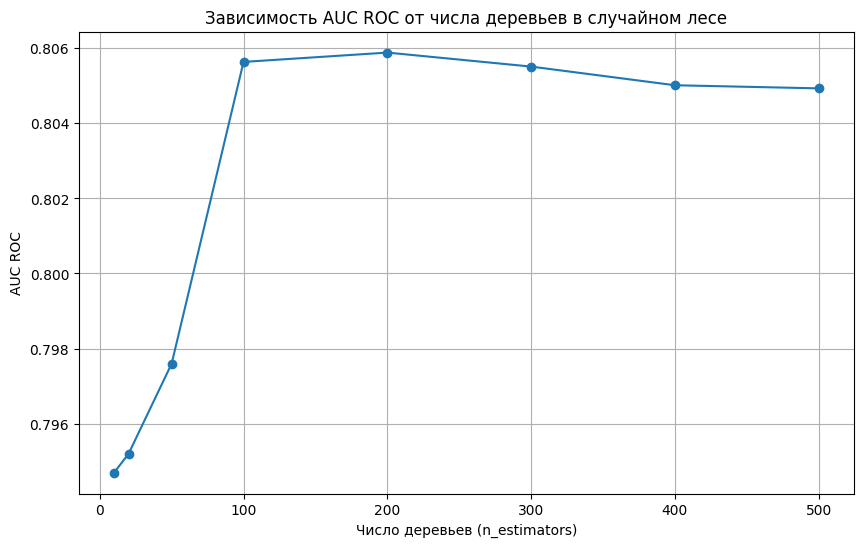

In [17]:
n_estimators_values = [10, 20, 50, 100, 200, 300, 400, 500]

auc_roc_scores = []

for n_estimators in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_test_prob = rf.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_test_prob)
    auc_roc_scores.append(auc_roc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, auc_roc_scores, marker='o')
plt.title('Зависимость AUC ROC от числа деревьев в случайном лесе')
plt.xlabel('Число деревьев (n_estimators)')
plt.ylabel('AUC ROC')
plt.grid(True)
plt.show()

Модели после значения числа дерьевьев >200 начинают переобучаться, поэтому показатель AUR-ROC падает.

**Задание 3.6 (0.5 балла)**

Для лучшей модели случайного леса из Задания 3.4 посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

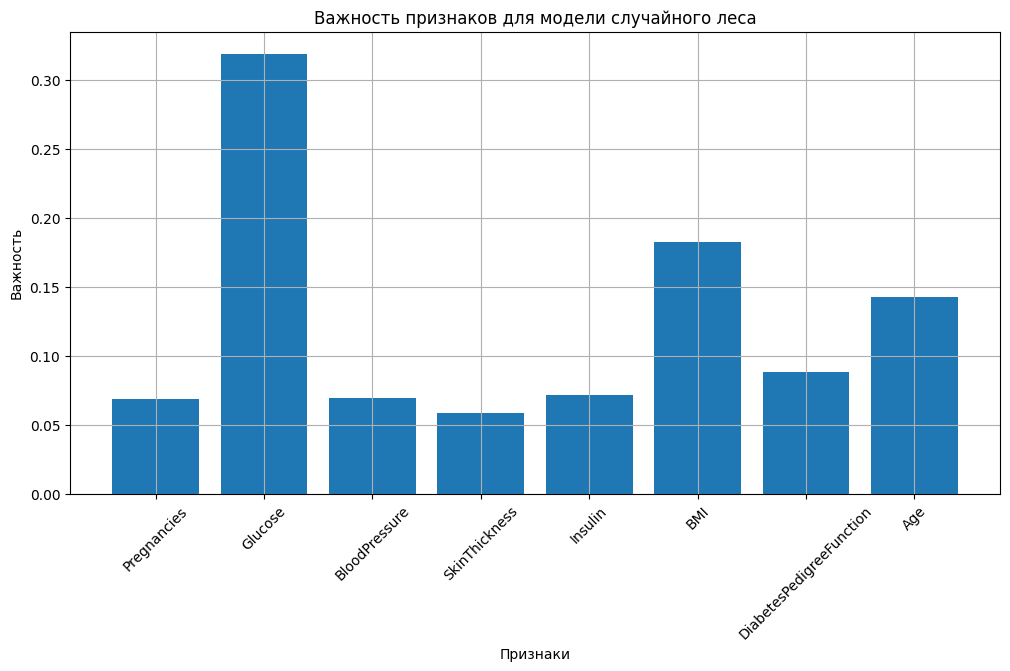

'Glucose'

In [18]:
best_max_depth = 10
best_min_samples_split = 15

best_rf = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth,
                                 min_samples_split=best_min_samples_split, random_state=52)
best_rf.fit(X_train, y_train)

feature_importances = best_rf.feature_importances_

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=X_train.columns)
plt.title('Важность признаков для модели случайного леса')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

most_important_feature = X_train.columns[np.argmax(feature_importances)]
most_important_feature

Самым важным оказался признак **Glucose**.